# Однородность PIN-диода

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter, find_peaks
from cycler import cycler

# Настройки визуализации
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    "figure.figsize": (8, 6),   
    "figure.dpi": 150,          
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,
    "errorbar.capsize": 1.5,
    'image.cmap': 'viridis',
     'axes.prop_cycle': cycler(color=plt.cm.plasma(np.linspace(0, 1, 5)))
})

SAVE_FIGS = False   
FIG_DPI   = 600    


## Загрузка данных

Заголовок файлов:

1. `x` — Положение (мм)  
2. `y` — Сигнал усреднённый (В)  
3. `delta` — Δ (мкм)  
4. `energy` — Энергия пучка   
5. `current` — Ток пучка   


In [13]:
def load_txt_columns(path, skiprows=1):
    """Загрузка файла. Возвращает массивы колонок:
    x, y, delta, energy, current.
    Возвращает None, если файл отсутствует
    """
    if not os.path.exists(path):
        print(f"[!] Файл не найден: {path}")
        return None
    data = np.loadtxt(path, skiprows=skiprows)
    
    x      = data[:, 0].astype(float)
    y      = data[:, 1].astype(float)
    delta  = data[:, 2].astype(float)
    energy = data[:, 3].astype(float)
    current= data[:, 4].astype(float)
    return x, y, delta, energy, current


def mask_range(x, x_min=None, x_max=None):
    """Возвращает маску для ограничения диапазона x
    (нужно для отображения графиков)
    """
    mask = np.ones_like(x, dtype=bool)
    if x_min is not None:
        mask &= (x >= x_min)
    if x_max is not None:
        mask &= (x <= x_max)
    return mask


# стандартная ошибка среднего, взятая при усреднении сигнала (темнового тока?)
# при приложенном напряжении 30 В и энергии 15 кэВ

ERR = "30_v_7_56_deg.txt"
err =  stats.sem(np.loadtxt(ERR,skiprows=1)[:,1])

## Определение «краев» и оценка фона
Для опрделения краев используется метод нахождение пиков второй производной. 
Поскольку данные зашумлены, производится сглаживание методом **Савицкого-Голея**.

##### *Примечание.* Сглаживание по Савицкому-Голею в некоторой степени видоизменяет данные, сохраняя их общий вид. Там, где значительное изменение данных происходит резко, следует уменьшить количество точек в параметре `window_length`. В связи с этим полезно отслеживать, как определяются пики и где они находятся, для чего включена отладка флагом `show`.

- `deriv` — производная;
- `find_edges` — сглаживание, поиск пиков второй производной;
- `bckg` — т.н. "фон" есть среднее по выбранной стороне от границы. Это сделано для приведения данных к общему виду, поскольку на данном этапе само значение сигнала не имеет значения. Важно лишь, чтобы разные измереия правильно соотносились между собой (для этого в т.ч. производится нормировка на ток накопителя и сдвиг к нулю некоторой фиктивной системы координат) 


In [101]:
def deriv(arr, h):
    """Производная по массиву arr с шагом h."""
    arr = np.asarray(arr, dtype=float)
    d = np.empty_like(arr)
    d[0]  = (arr[1]   - arr[0])   / h
    d[-1] = (arr[-1]  - arr[-2])  / h
    d[1:-1] = (arr[2:] - arr[:-2]) / (2*h)
    return d

def find_edges(x, y, window_length=20, polyorder=1, h=1e-2, height=0.004, distance=20, show=True, title=None,savgol_filter=True):
    """Возвращает координаты пиков второй производной ("границы").
    Параметры:
    window_lenght - количество точек, по которым делается сглаживание;
    polyorder - порядок полинома, которым аппроксимируется массив данных;
    h - шаг для производной;
    height, distance - параметры для нахождения пиков 
    (минимальные высота пика и минимальное расстояние между пиками);
    show - флаг для демонстрации графиков (отладка);
    title - название графиков.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if savgol_filter:
    # 1-я и 2-я производные с сглаживанием Савицкого-Голея
        d1 = savgol_filter(deriv(y, h),  window_length, polyorder, mode='interp')
        d2 = np.abs(savgol_filter(deriv(d1, h), window_length, polyorder, mode='interp'))

    else:
        d1 = deriv(y, h)
        d2 = np.abs(deriv(d1, h))
        
        
    # Поиск пиков второй производной
    peaks, info = find_peaks(d2, height=height, distance=distance)
    x_peaks, y_peaks = x[peaks], d2[peaks]

    if show:
        plt.figure()
        plt.plot(x, y, label="f(x)")
        plt.plot(x, d1, label="f'(x)")
        plt.plot(x, d2, label="|f''(x)|")
        plt.plot(x_peaks, y_peaks, 'o', label='peaks')
        if title:
            plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        if SAVE_FIGS and title:
            plt.savefig(f"{title.replace(' ', '_')}_edges.png", dpi=FIG_DPI)
        plt.show()

    # Печать координат пиков
    for i, (xp, yp) in enumerate(zip(x_peaks, y_peaks), 1):
        print(f"{i}: x={xp:.6g}, |f''|={yp:.6g}")
    return x_peaks

def bckg(x, y, border, sign):
    """Среднее значение y слева или справа от 'border'.
    Если sign > 0 — берём x <= border, иначе x >= border.
    Используется для оценки фона до/после скачка.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if sign > 0:
        vals = y[x <= border]
    else:
        vals = y[x >= border]
    return np.mean(vals) if vals.size else 0.


In [39]:
def signal_analysis(name, arrays, peak_kwargs=None, x_shift_side='min', sign=None,show_flag=False):
    x, y, delta, energy, current = arrays
    y_norm = -y/current
    # задание параметров для производной, сглаживания и нахождения пиков
    pk = dict(window_length=20, polyorder=1, h=1e-2, height=0.004, distance=20, show=show_flag)
    if peak_kwargs: pk.update(peak_kwargs)
    
    # нахождение границ (массив координат по x)
    borders = find_edges(x, y_norm, **pk, title=None)
    
    # сдвиг графиков к единому нулю

    if x_shift_side == 'min':
        x0 = np.min(borders)
    elif x_shift_side == 'max':
        x0 = np.max(borders)
    else: 
        x0=0.
    x_shifted = x - x0

    # вычитание фона
    if x_shift_side == 'min':
        bg = bckg(x_shifted, y_norm, np.min(borders)-x0, sign)
    elif x_shift_side == 'max':
        bg = bckg(x_shifted, y_norm, np.max(borders)-x0, sign)
    else:
        bg = 0 #bckg(x_shifted, y_norm, np.min(borders), sign)
        


    # график для каждого отдельного измерения
    if show_flag:
        plt.figure()
        plt.errorbar(x_shifted, y_norm - bg, xerr=np.abs(delta)/1000.0, fmt='-o', ms=3, lw=1.8, label=name)
        for b in borders:
            plt.axvline(b - x0, ls='-', lw=1.5)
        plt.axvline(0.0, color='k', lw=1.0)

        plt.title(f"{name}")
        plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, усл. ед.")
        plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout()

        if SAVE_FIGS: plt.savefig(f"{name.replace(' ', '_')}_knife_edges.png", dpi=FIG_DPI)
        plt.show()


    if len(borders)<=2:
        width = float(np.abs(np.max(borders) - np.min(borders)))
    else:
        borders=np.sort(borders)
        width = float(np.abs(borders[2] - borders[0]))
    print(f"{name}: ширина рабочей области = {width:.3f} мм")    
    return (x_shifted, y_norm-bg, delta), borders, width


## Путь к данным и имена файлов

`Левый нож` / `Правый нож` — сканирование по горизонтали при вертикальной координате 4 мм 

`Левый нож 2` / `Правый нож 2` — сканирование по горизонтали при вертикальной координате 3.5 мм (там был дефект)

`По вертикали сверху-вниз` / `По вертикали снизу-вверх` — сканирование по вертикали в разных направлениях (гистерезис) 

`По вертикали сверху-вниз2` / `По вертикали снизу-вверх2` — то же самое; второе измерение 

`Спектр СИ` — по нему определяли нуль гониометра


In [40]:
LEFT_1 = "Левый нож.txt"
LEFT_2 = "Левый нож 2.txt"
RIGHT_1 = "Правый нож.txt"
RIGHT_2 = "Правый нож 2.txt"

VERT_UD_1 = "По вертикали сверху-вниз.txt"
VERT_UD_2 = "По вертикали сверху-вниз2.txt"
VERT_DU_1 = "По вертикали снизу-вверх.txt"
VERT_DU_2 = "По вертикали снизу-вверх2.txt"


In [6]:
left1 = load_txt_columns(LEFT_1)
left2 = load_txt_columns(LEFT_2)
right1 = load_txt_columns(RIGHT_1)
right2 = load_txt_columns(RIGHT_2)

vud1 = load_txt_columns(VERT_UD_1)
vud2 = load_txt_columns(VERT_UD_2)
vdu1 = load_txt_columns(VERT_DU_1)
vdu2 = load_txt_columns(VERT_DU_2)


## Горизонтальные сканы


1: x=12.1501, |f''|=0.00704049
2: x=7.66269, |f''|=0.00588136
Движение левого ножа: ширина рабочей области = 4.487 мм
1: x=12.1451, |f''|=0.00591791
2: x=7.6907, |f''|=0.006036
Движение левый ножа, 2 измерение: ширина рабочей области = 4.454 мм
1: x=17.3013, |f''|=0.00585108
2: x=21.7571, |f''|=0.00610921
Движение правого ножа: ширина рабочей области = 4.456 мм
1: x=17.2977, |f''|=0.00597671
2: x=21.7499, |f''|=0.00619838
Движение правого ножа, 2 измерение: ширина рабочей области = 4.452 мм


<IPython.core.display.Javascript object>


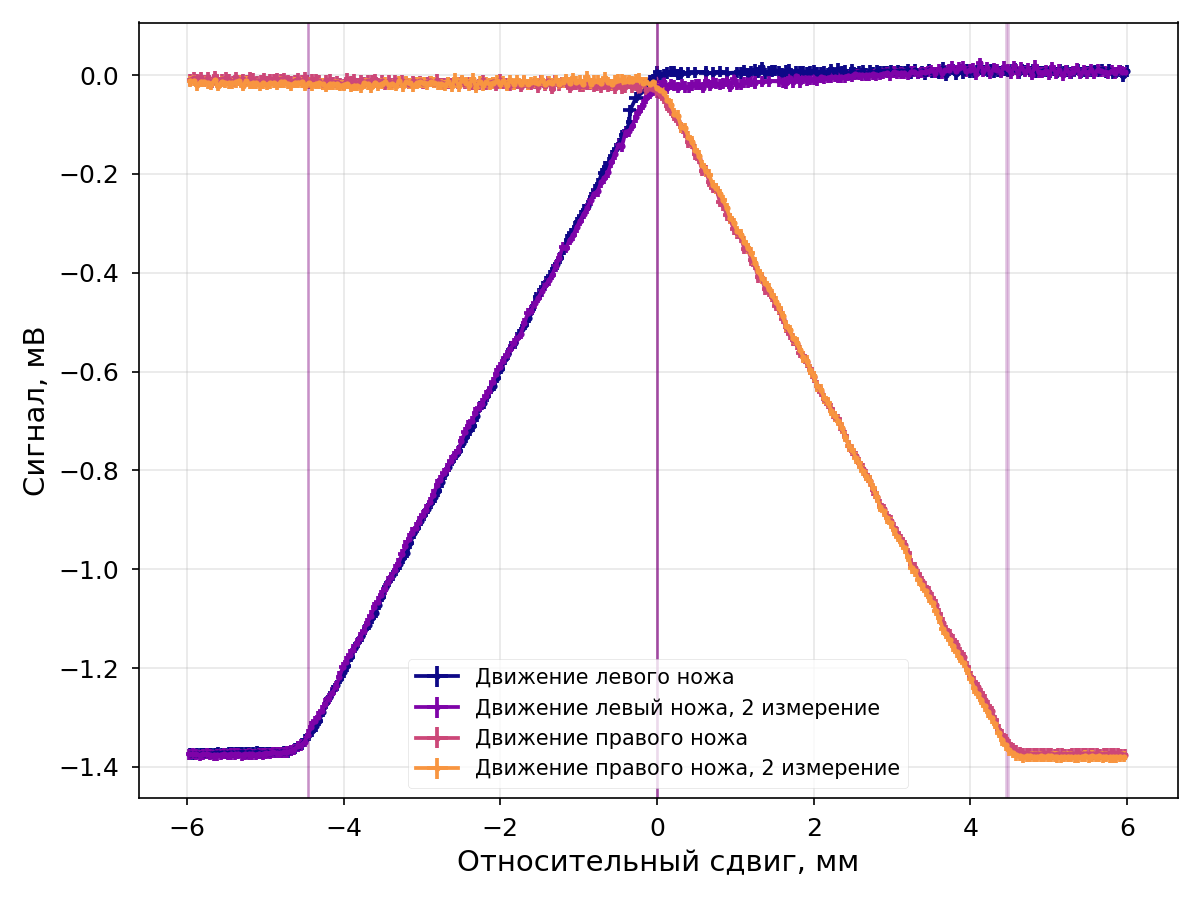

In [7]:
%matplotlib notebook

Horizontal_datlist = []

for label, arr in [("Движение левого ножа", left1), ("Движение левый ножа, 2 измерение", left2)]:
    triple, borders, widths = signal_analysis(label, arr,x_shift_side='max',sign=-1)
    Horizontal_datlist.append((label, triple, borders-min(borders), widths))

for label, arr in [("Движение правого ножа", right1), ("Движение правого ножа, 2 измерение", right2)]:
    triple, borders, widths = signal_analysis(label, arr,x_shift_side='min',sign=1)
    Horizontal_datlist.append((label, triple, borders-max(borders), widths))
    
plt.figure()
for i, (label, triple, borders, widths) in enumerate(Horizontal_datlist):
    if triple is None: 
        continue
    x, y_norm, delta = triple
    if i<2:
        m = mask_range(x, -6.0, 6.0)
    else:
        m = mask_range(x, -6.0, 6.0)
    plt.errorbar(x[m], y_norm[m]*1000, xerr=np.abs(delta[m])/1000.0,yerr=err*1000/np.sqrt(10), fmt='-o', ms=3, lw=1.8, label=label)
    if borders is not None and len(borders) > 0:
        for b in borders:
            if -6.0 <= b <= 6.0:
                plt.axvline(b, ls='-', lw=1.2,color='purple',alpha=0.25)

plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, мВ")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
if SAVE_FIGS: plt.savefig("horizontal_scans.png", dpi=FIG_DPI)
plt.show()

## Вертикальные сканы


1: x=7.27599, |f''|=0.179592
2: x=6.66455, |f''|=0.173369
3: x=2.48841, |f''|=0.167062
4: x=1.76666, |f''|=0.179349
Сканирование сверху вниз: ширина рабочей области = 4.898 мм
1: x=7.35099, |f''|=0.231936
2: x=6.68001, |f''|=0.16534
3: x=2.51776, |f''|=0.178537
4: x=1.79255, |f''|=0.179191
Сканирование сверху вниз, 2 измерение: ширина рабочей области = 4.887 мм
1: x=1.74294, |f''|=0.2288
2: x=2.40231, |f''|=0.157819
3: x=6.5737, |f''|=0.169217
4: x=7.2417, |f''|=0.178673
Сканирование снизу вверх: ширина рабочей области = 4.831 мм
1: x=1.65295, |f''|=0.219654
2: x=2.32129, |f''|=0.256146
3: x=6.59805, |f''|=0.280612
4: x=7.26835, |f''|=0.250856
Сканирование снизу вверх, 2 измерение: ширина рабочей области = 4.945 мм


<IPython.core.display.Javascript object>


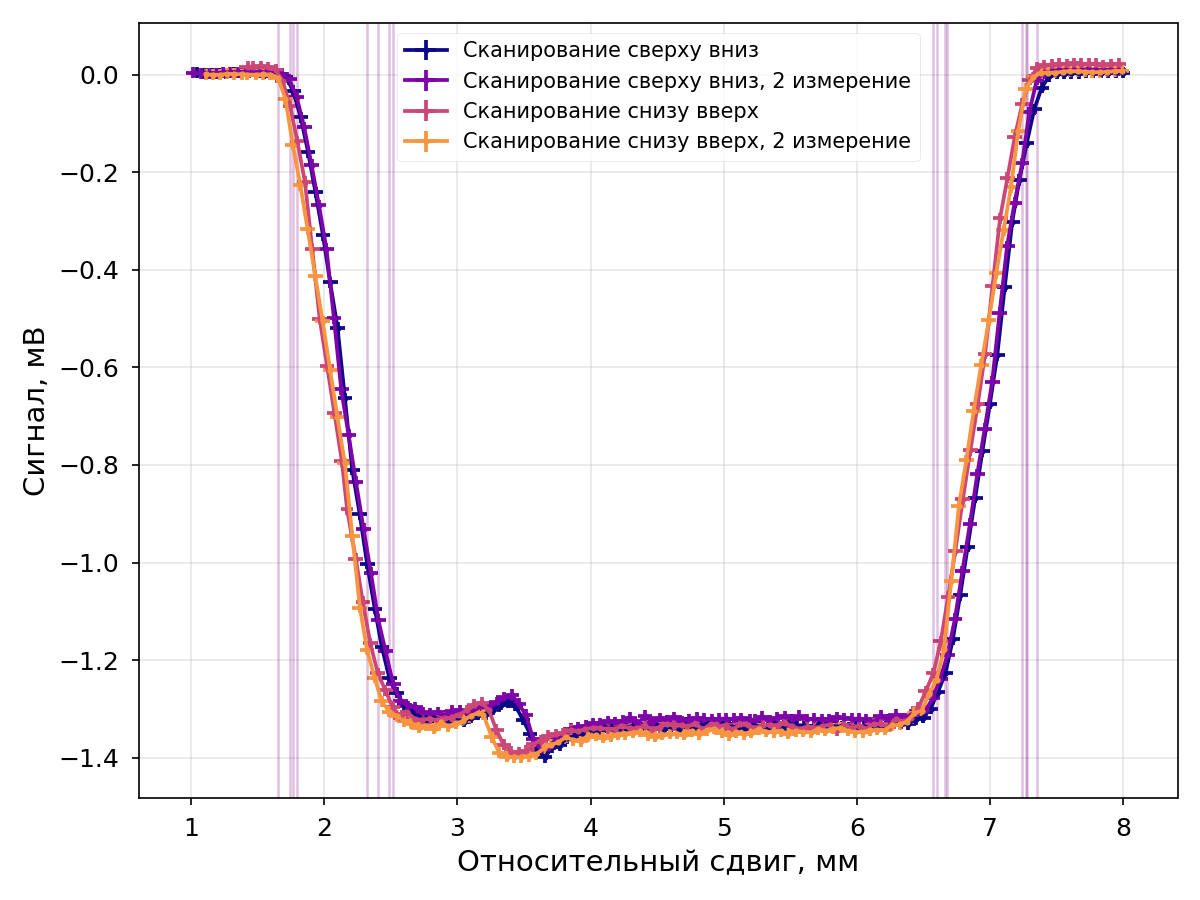

In [8]:
Vertical_datlist = []
for label, arr in [("Сканирование сверху вниз", vud1), ("Сканирование сверху вниз, 2 измерение", vud2),
                   ("Сканирование снизу вверх", vdu1), ("Сканирование снизу вверх, 2 измерение", vdu2)]:
    triple, borders, widths = signal_analysis(label, arr, 
                                              peak_kwargs=({'window_length':3, 'distance':5, 'height':0.15}),
                                              x_shift_side=None,sign=1)
    Vertical_datlist.append((label, triple, borders, widths))

    
plt.figure()
for label, triple, borders, widths in Vertical_datlist:
    if triple is None: 
        continue
    x, y_norm, delta = triple
    m = mask_range(x, 1.0, 8.0)
    plt.errorbar(x[m], -y_norm[m]*1000, xerr=np.abs(delta[m])/1000.0, yerr=err*1000/np.sqrt(10), fmt='-o', ms=3, lw=1.8, label=label)
    if borders is not None and len(borders) > 0:
        for b in borders:
            if 1.0 <= b <= 8.0:
                plt.axvline(b, ls='-', lw=1.2,color='purple',alpha=0.25)

plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, мВ")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
if SAVE_FIGS: plt.savefig("vertical_scans.png", dpi=FIG_DPI)
plt.show()

## Деградация

`Профиль до облучения` — сканирование по вертикали при энергии 9 кэВ 

`Профиль после облучения белым пучком` / `Профиль после облучения белым пучком2` — два сканирования по вертикали при при энергии 9 кэВ после облучения БП


In [9]:
BEFORE = "Профиль до облучения.txt"
AFTER = "Профиль после облучения белым пучком.txt"
AFTER2 = "Профиль после облучения белым пучком2.txt"

before = load_txt_columns(BEFORE)
after = load_txt_columns(AFTER)
after2 = load_txt_columns(AFTER2)

1: x=1.45276, |f''|=0.0908137
2: x=2.00389, |f''|=0.085369
3: x=6.42024, |f''|=0.111941
4: x=6.8562, |f''|=0.100821
До облучения: ширина рабочей области = 4.967 мм
1: x=9.01117, |f''|=0.156878
2: x=9.56718, |f''|=0.151833
3: x=13.8594, |f''|=0.199831
4: x=14.2743, |f''|=0.185278
После облучения: ширина рабочей области = 4.848 мм
1: x=14.5434, |f''|=0.152977
2: x=14.0034, |f''|=0.167661
3: x=9.82405, |f''|=0.185876
4: x=9.27188, |f''|=0.163393
После облучения, 2 измерение: ширина рабочей области = 4.732 мм


<IPython.core.display.Javascript object>


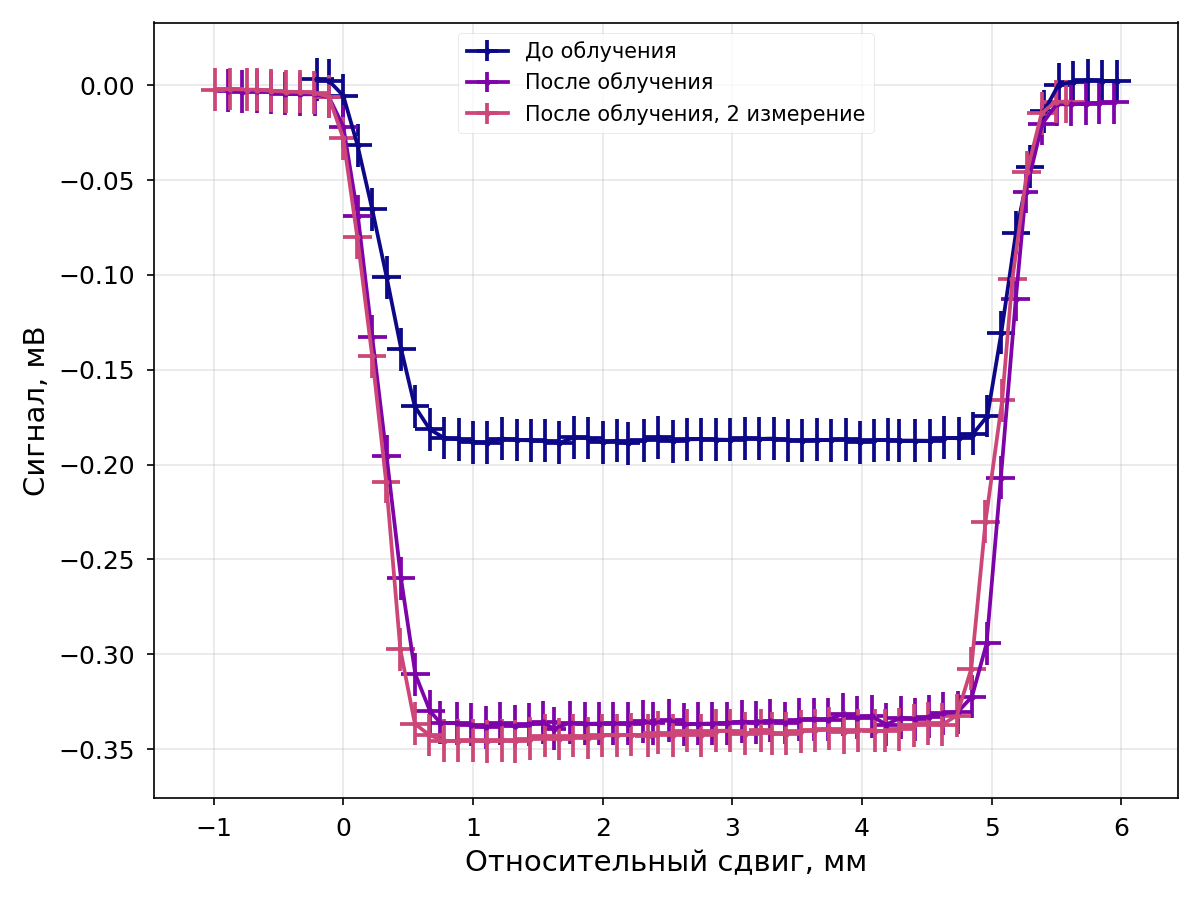

In [10]:
degr_datlist = []
for label, arr in [("До облучения", before), ("После облучения", after), ("После облучения, 2 измерение", after2)]:
    triple, borders, widths = signal_analysis(label, arr, 
                                              peak_kwargs=({'window_length':3, 'distance':2, 'height':0.08}),
                                              x_shift_side='min',sign=1)
    degr_datlist.append((label, triple, borders, widths))

    
plt.figure()
for label, triple, borders,widths in degr_datlist:
    if triple is None: 
        continue
    x, y_norm, delta = triple
    m = mask_range(x, -1.0, 6.0)
    plt.errorbar(x[m], -y_norm[m]*1000, xerr=np.abs(delta[m])/1000.0, yerr=err*1000/np.sqrt(10), fmt='-o', ms=3, lw=1.8, label=label)

plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, мВ")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
if SAVE_FIGS: plt.savefig("degrad.png", dpi=FIG_DPI)
plt.show()

## Щель
СИ ограничено прямоугольной щелью, образуемую пластинами, выполненными из сплава эльконайта, толщиной 5 мм

1: x=12.7293, |f''|=1585.54
2: x=12.3943, |f''|=1606.41
3: x=7.61889, |f''|=1735.12
4: x=7.28144, |f''|=1817.52
1: ширина рабочей области = 5.113 мм
1: x=7.08514, |f''|=1535.7
2: x=7.41739, |f''|=1648.42
3: x=11.9589, |f''|=1856.25
4: x=12.3978, |f''|=1689.99
2: ширина рабочей области = 4.874 мм


<IPython.core.display.Javascript object>


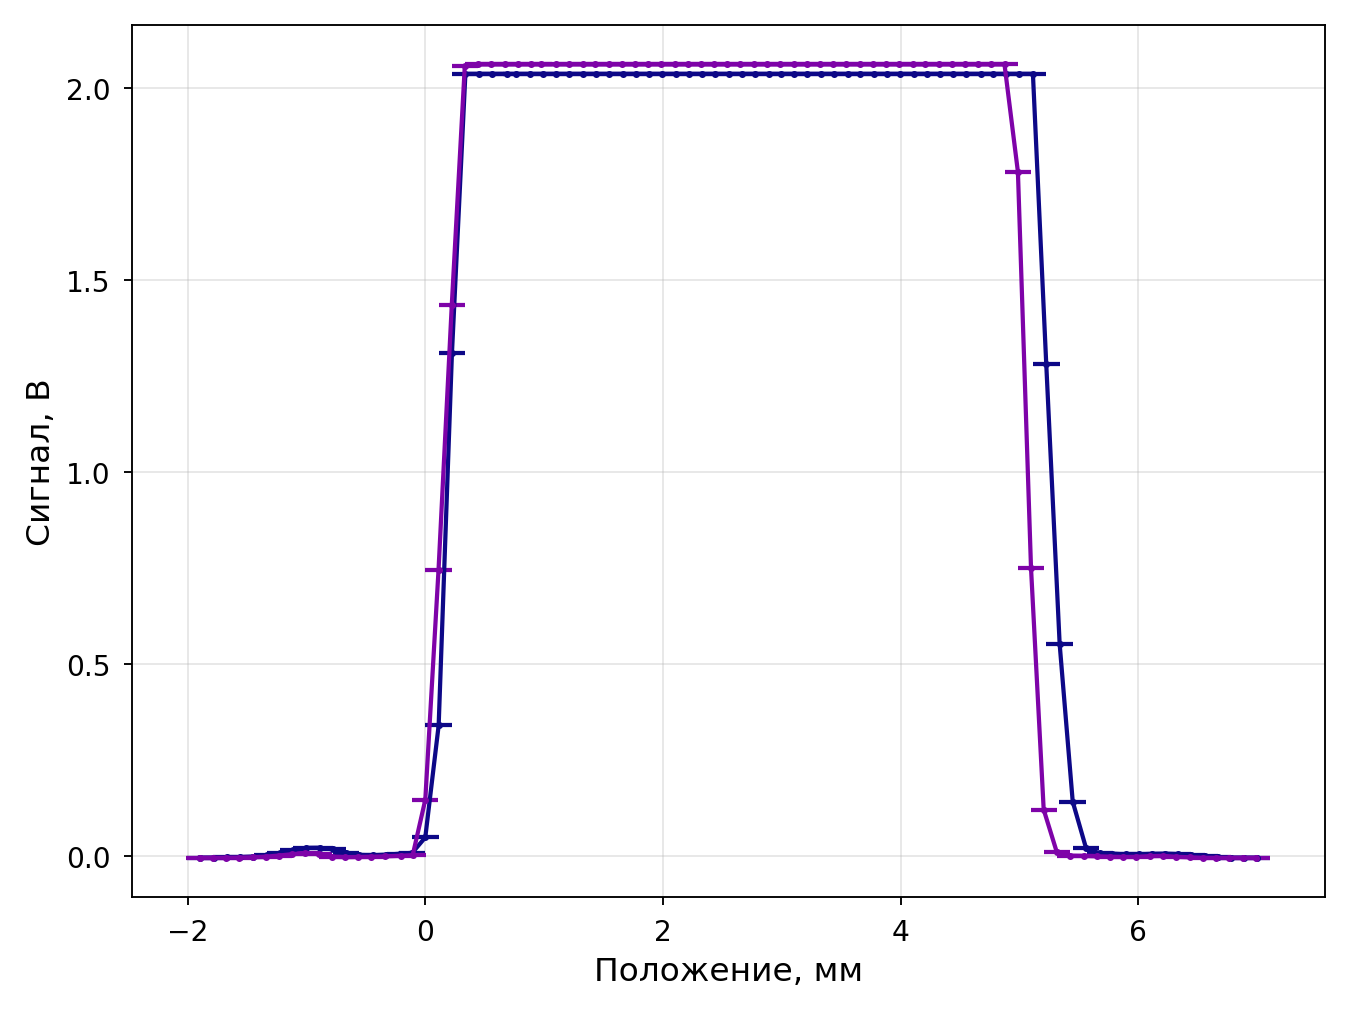

In [55]:
STR1="gusev\\Прямой пучок1.txt"
STR2="gusev\\Прямой пучок2.txt"

str1 = load_txt_columns(STR1)
str2 = load_txt_columns(STR2)

Beam_datlist = []

for label, arr in [("1", str1), ("2", str2)]:
    triple, borders, widths = signal_analysis(label, arr,
                                              peak_kwargs=({'window_length':3, 'distance':2, 'height':1500}),
                                              x_shift_side='min',sign=1)
    Beam_datlist.append((label, triple, borders-min(borders), widths))


plt.figure()
for i, (label, triple, borders, widths) in enumerate(Beam_datlist):
    if triple is None: 
        continue
    x, y_norm, delta = triple
    m = mask_range(x, -2.0, 7.0)
    plt.errorbar(x[m], y_norm[m], xerr=np.abs(delta[m])/1000.0, fmt='-o', ms=3, lw=1.8, label=label)

plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, В")
plt.grid(True, alpha=0.3)
plt.tight_layout()
if SAVE_FIGS: plt.savefig("beam_with_slits.png", dpi=FIG_DPI)
plt.show()



## Профиль пучка

<IPython.core.display.Javascript object>


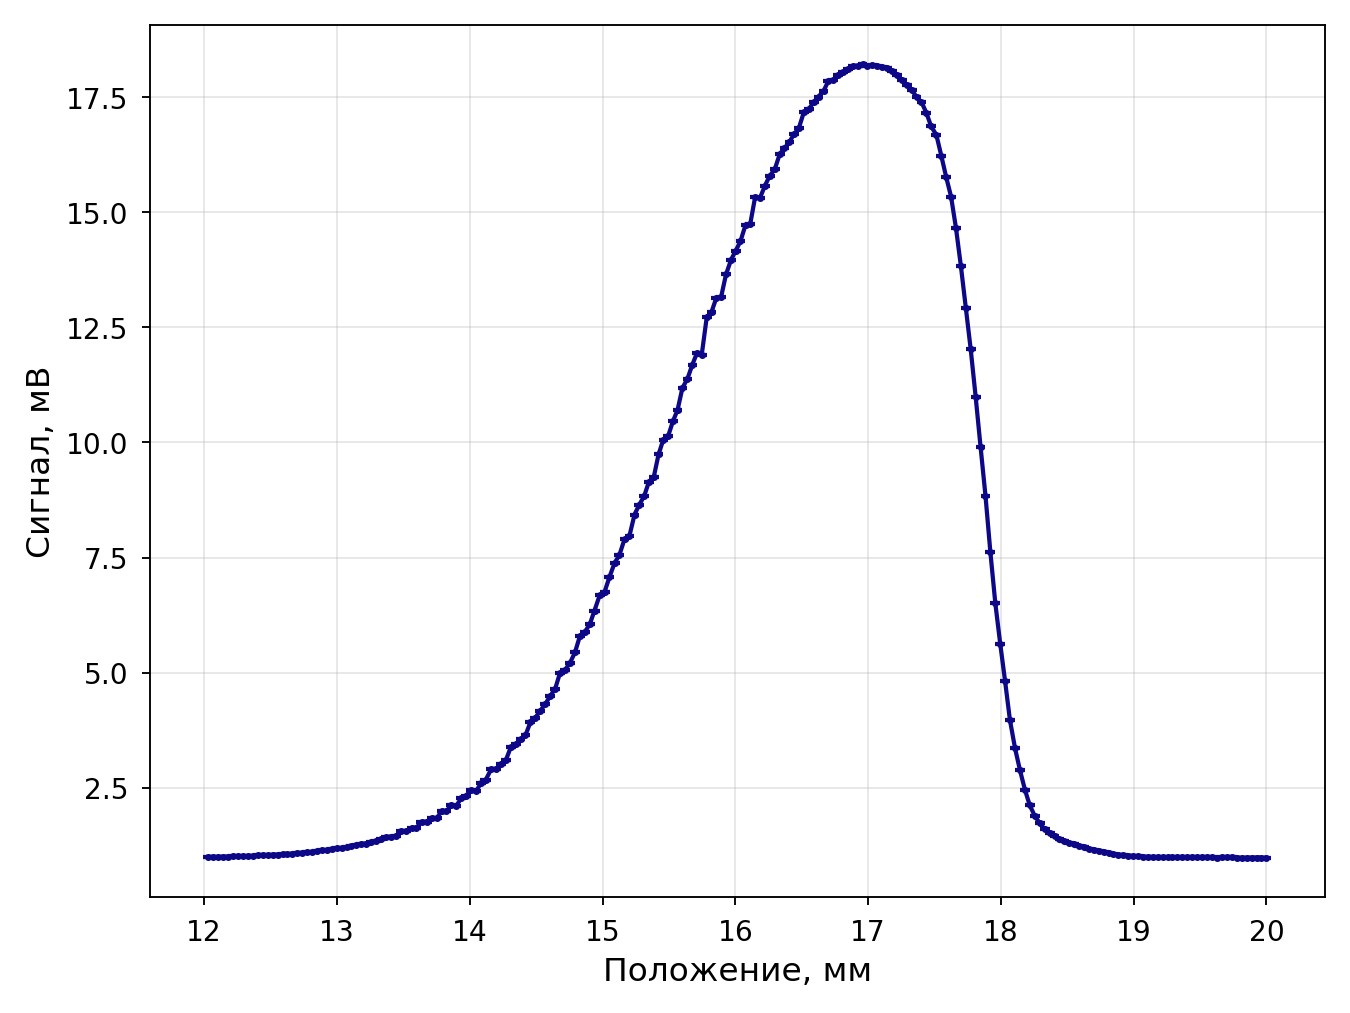

In [31]:
BPROF = "gusev\\Профиль пучка СИ 4.5 Гэв (Слева мусор).txt"
x, y, dx = np.loadtxt(BPROF, skiprows=1, unpack=True)
m = mask_range(x, 12., 20.)
plt.errorbar(x[m], y[m]*1000, xerr = np.abs(dx[m])/1000, fmt='-o', ms=3, lw=1.8)
plt.xlabel("Положение, мм"); plt.ylabel("Сигнал, мВ")
plt.grid(True, alpha=0.3)
plt.tight_layout()
if SAVE_FIGS: plt.savefig("beam_prof.png", dpi=FIG_DPI)
plt.show()

## Определение нуля гониометра 

Нужно определить точно край поглощения (вторая производная)

<IPython.core.display.Javascript object>


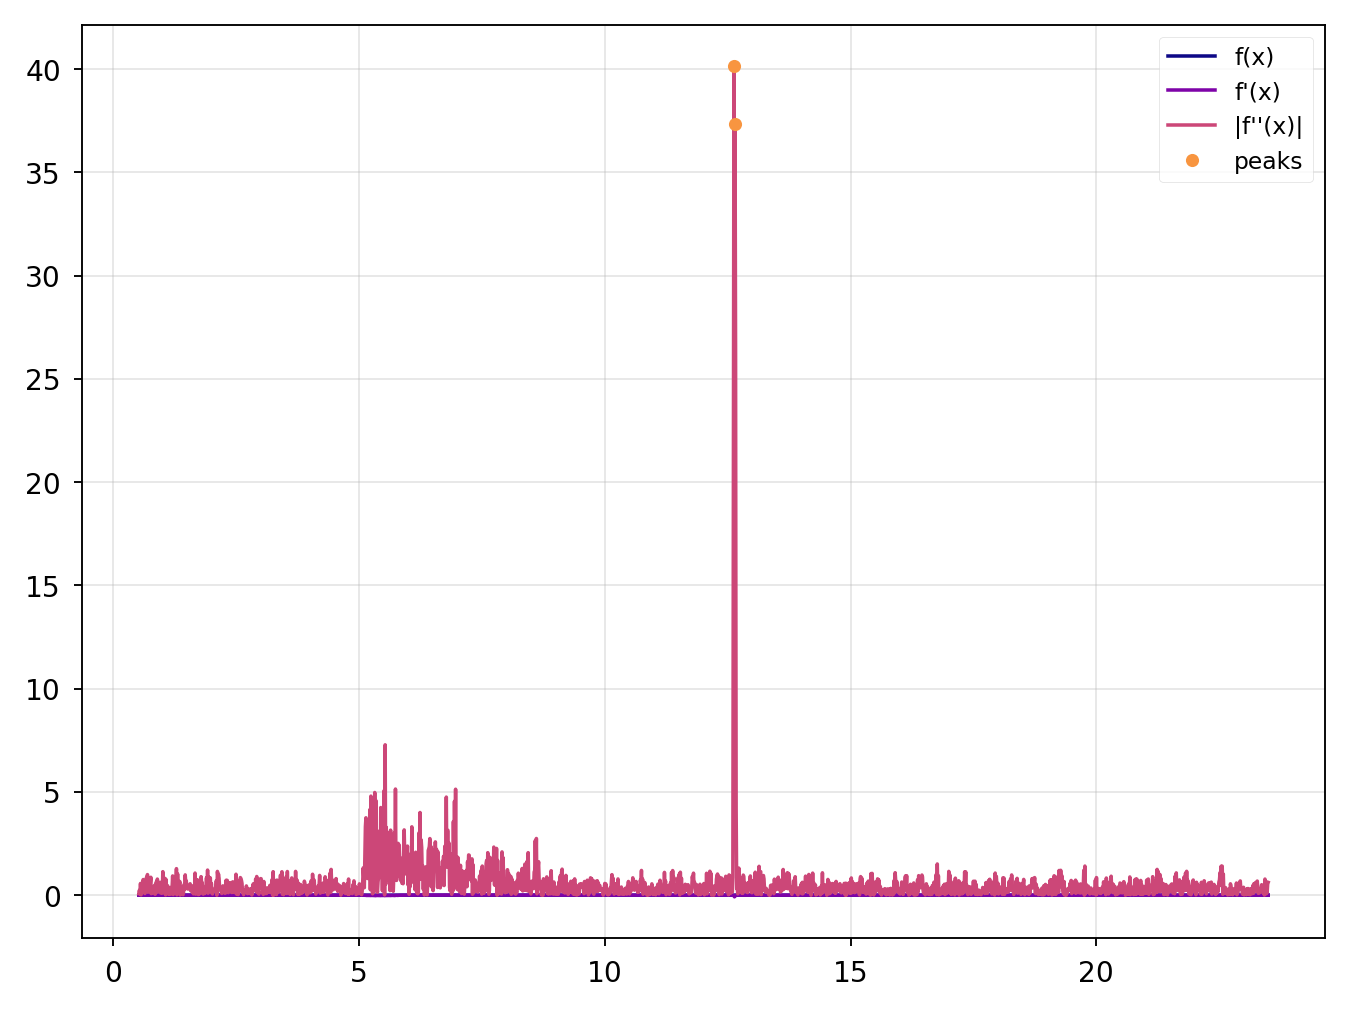

1: x=12.6279, |f''|=40.139
2: x=12.65, |f''|=37.3403


<IPython.core.display.Javascript object>


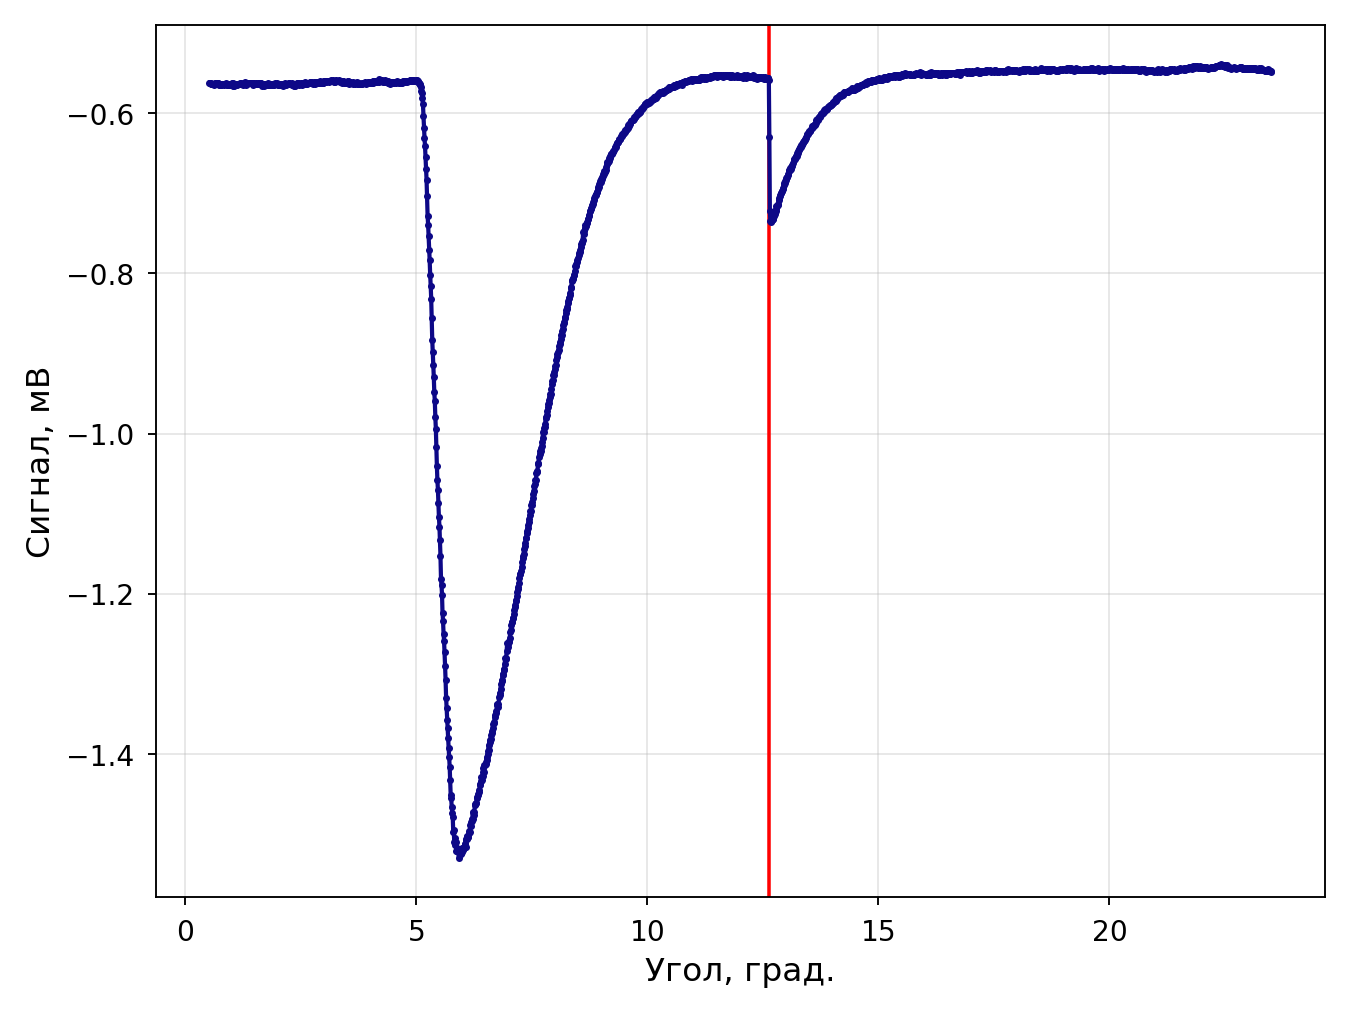

Угол:  12.639 +/- 0.011
Нуль гониометра:  0.299


In [128]:
def energy2angle(energy: float) -> float:
    """Перевод энергии (кэВ) в угол (градусы)"""
    
    return np.arcsin(12.39841 / (2 * energy* (5.341 / np.sqrt(3))))*180/np.pi

CU="gusev\\Спектр пропускания CU 30 мкм.txt"
cu = load_txt_columns(CU)

zero_angle = find_edges(cu[0], cu[1]/cu[4], h=1e-3, height=35, distance=2, savgol_filter=False)
plt.figure()
plt.errorbar(cu[0],cu[1]/cu[4]*1000, xerr=np.abs(cu[2])/1000, fmt='-o', ms=3, lw=1.8)
plt.axvline(np.mean(zero_angle),color='red')
plt.xlabel("Угол, град."); plt.ylabel("Сигнал, мВ")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Угол: ", f"{np.mean(zero_angle):.3f}","+/-", f"{stats.sem(zero_angle):.3f}")
print("Нуль гониометра: ",f"{energy2angle(8.9789)-np.mean(zero_angle):.3f}")
